# Construindo e treinamento o modelo

Para a construção do modelo, utilizei como base o código do cientista de dados Leandro Alencar, que pode ser encontrado em sua publicação no Kaggle: https://www.kaggle.com/code/leandroal/an-lise-de-sentimento-de-tweets-na-blackfiday

Leandro utiliza uma base de dados de reviews de produtos da Amazon para alimentar o modelo. Como já possuo uma base de dados de publicações do Instagram e Twitter de Senadores e Deputados Federais brasileiros, não coloquei os dados para a raspagem. Depois, utilizei este modelo para analisar as publicações desses políticos, separando por temas importantes para as políticas públicas do país - em especial Reforma Tributária e Saneamento Básico. 

## Importar as bibliotecas necessárias

Nesta seção, estamos importando as bibliotecas necessárias para o projeto de análise de sentimento em Python. As bibliotecas incluem pandas, numpy, nltk, spacy, re, unidecode, gensim, matplotlib, seaborn e sklearn. Essas bibliotecas serão usadas para manipulação de dados, processamento de texto, visualização e construção do modelo de análise de sentimento.

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 400)
import numpy as np
import nltk
from nltk import FreqDist
import spacy
import re
from unidecode import unidecode

import pandas as pd
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import multiprocessing

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss,confusion_matrix
import math

import  warnings
warnings.filterwarnings("ignore")

## Importação dos dados e pré-processamento inicial
Nesta seção, estamos importando o conjunto de dados de avaliações do arquivo CSV especificado. A base de dados utilizada para a construção da análise de sentimentos são as avaliações de produtos da Amazon em português. 

In [2]:
%%time
file = "B2W-Reviews01.csv"
b2w_raw = pd.read_csv(file, encoding='utf-8', low_memory=False)
b2w = b2w_raw[['review_text', 'overall_rating']]

b2w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_text     129098 non-null  object
 1   overall_rating  132373 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB
CPU times: total: 594 ms
Wall time: 943 ms


O método abaixo calcula estatísticas descritivas sobre o comprimento das avaliações de texto.

In [3]:
b2w['review_text'].str.len().describe()


count    129098.000000
mean        136.746154
std         126.364490
min          50.000000
25%          68.000000
50%          95.000000
75%         155.000000
max        4548.000000
Name: review_text, dtype: float64

Em seguida, verificamos se há avaliações nulas e exibimos a contagem de avaliações nulas.
Removemos as avaliações nulas do DataFrame

In [4]:
print('Avaliações nulas: ', b2w['review_text'].isnull().sum())
# Delete null from review_text
b2w = b2w[b2w['review_text'].notnull()]


Avaliações nulas:  3275


Em seguida, verificamos e removemos registros duplicados e, por fim, exibimos o formato do dataset após a remoção de duplicados.  

In [5]:
print('Registros duplicados: ', b2w.duplicated(keep=False).sum())
b2w = b2w.drop_duplicates().reset_index(drop=True)
print('Formato do dataset após remoção de duplicados:', b2w.shape)



Registros duplicados:  3989
Formato do dataset após remoção de duplicados: (126793, 2)


## Visualização da distribuição das classes de avaliação
Nesta seção, estamos visualizando a distribuição das classes de avaliação no conjunto de dados. Primeiro, contamos o número de ocorrências de cada valor de avaliação. Em seguida, ordenamos os valores por ordem crescente usando sort_values('index') e selecionamos apenas a coluna de contagens. Armazenamos as contagens de avaliação em uma lista chamada rating_counts e calculamos a proporção de cada valor de avaliação em relação ao total, arredondamos os valores para uma casa decimal e convertemos para uma lista formatada como porcentagem. Depois, também armazenamos as proporções de avaliação em uma lista chamada rating_p. Em seguida, criamos um gráfico de barras usando sns.countplot(x=b2w['overall_rating']) para visualizar a distribuição das classes de avaliação. Definimos os rótulos e títulos adequados para o gráfico. Por fim, adicionamos as porcentagens de cada classe acima das barras do gráfico.  

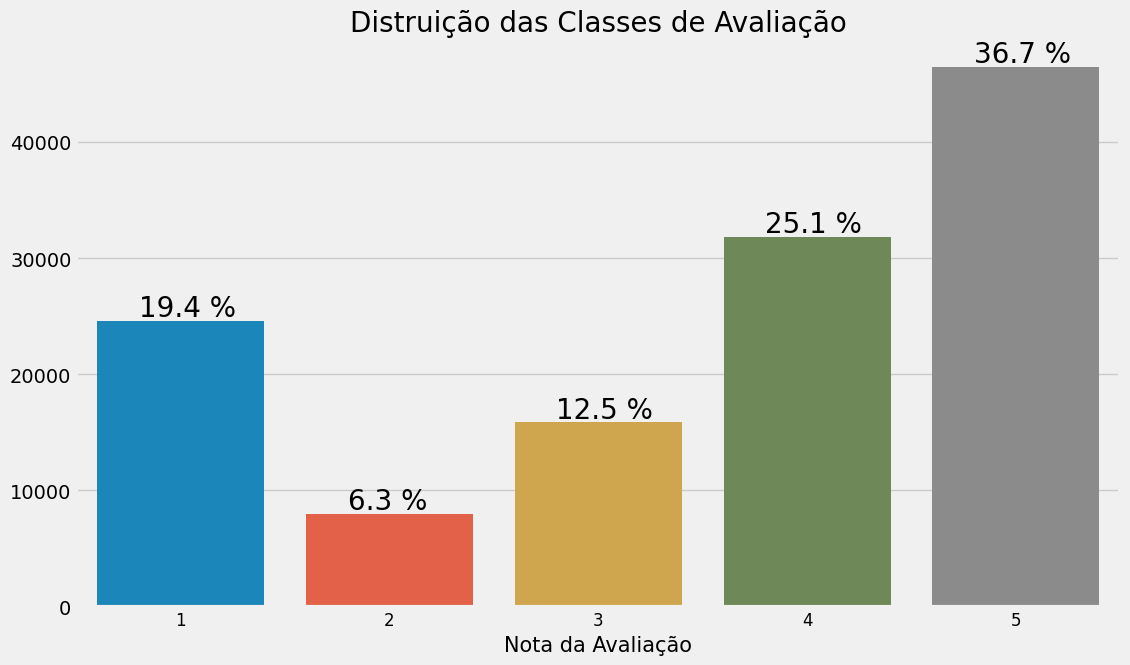

In [6]:
rating_counts = b2w['overall_rating'].value_counts().reset_index().sort_values('index').iloc[:,1].tolist()
rating_p = round(b2w['overall_rating'].value_counts(normalize=True).reset_index().sort_values('index').iloc[:,1] * 100, 1).apply(lambda x: '{} %'.format(x)).tolist()

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.countplot(x=b2w['overall_rating'])
plt.xticks(fontsize=12)
plt.title('Distruição das Classes de Avaliação',fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Nota da Avaliação', size=15)
for i, v in enumerate(rating_counts):
    ax.text(i-0.2, v+400, rating_p[i], size=20)

Exibimos a distribuição quantitativa e percentual das avaliações no conjunto de dados, 1º para contar o número de ocorrências de cada valor de avaliação e exibir a distribuição quantitativa das avaliações; e 2º para calcular a proporção de cada valor de avaliação em relação ao total e exibir a distribuição percentual das avaliações.

In [7]:
print('Distribuição Quantitativa:\n', b2w['overall_rating'].value_counts())

print('\nDistribuição Percentual:\n', b2w['overall_rating'].value_counts(normalize=True))

Distribuição Quantitativa:
 5    46513
4    31813
1    24610
3    15862
2     7995
Name: overall_rating, dtype: int64

Distribuição Percentual:
 5    0.366842
4    0.250905
1    0.194096
3    0.125102
2    0.063056
Name: overall_rating, dtype: float64


## Balanceamento do conjunto de dados

Nesta seção, estamos realizando o balanceamento do conjunto de dados, visando ter uma quantidade igual de avaliações positivas e negativas:
- Primeiro, selecionamos as avaliações positivas (com classificação igual a 5) e as avaliações negativas (com classificação menor ou igual a 2). 
- Em seguida, concatenamos as avaliações positivas e negativas em um novo DataFrame chamado b2w_ml usando pd.concat().
- Criamos um mapeamento para substituir os valores de classificação por "Positivo" e "Negativo" usando b2w_ml.replace(maping), onde maping é um dicionário definido anteriormente.
- Usando np.random.seed(seed=100), definimos a semente do gerador de números aleatórios para garantir a reprodutibilidade.
- Selecionamos aleatoriamente 20.000 avaliações positivas e 20.000 avaliações negativas do DataFrame b2w_ml usando np.random.choice().
- Concatenamos as avaliações selecionadas em uma única matriz chamada select.
- Filtramos o DataFrame b2w_ml para manter apenas as avaliações presentes na matriz select usando b2w_ml[b2w_ml['review_text'].isin(select)].
- Embaralhamos aleatoriamente as linhas do DataFrame b2w_ml usando b2w_ml.sample(frac=1).
- Em seguida, exibimos a distribuição percentual das classificações no conjunto de dados balanceado usando b2w_ml['overall_rating'].value_counts(normalize=True).
- Por fim, exibimos o formato do DataFrame b2w_ml usando b2w_ml.shape.

In [8]:

pos = b2w[['review_text', 'overall_rating']][b2w['overall_rating'] == 5]
neg = b2w[['review_text', 'overall_rating']][b2w['overall_rating'] <= 2]

b2w_ml = pd.concat([pos, neg])
maping = {5: 'Positivo'
         ,2: 'Negativo'
         ,1: 'Negativo'}
b2w_ml = b2w_ml.replace(maping)

np.random.seed(seed=100)
pos = np.random.choice(b2w_ml['review_text'][b2w_ml['overall_rating'] == 'Positivo'], 20000, replace=False)
neg = np.random.choice(b2w_ml['review_text'][b2w_ml['overall_rating'] == 'Negativo'], 20000, replace=False)
select = np.concatenate([pos, neg])

b2w_ml = b2w_ml[b2w_ml['review_text'].isin(select)].reset_index(drop=True)
b2w_ml = b2w_ml.sample(frac=1).reset_index(drop=True)

print(b2w_ml['overall_rating'].value_counts(normalize=True))
print("\n", b2w_ml.shape)

Negativo    0.500012
Positivo    0.499988
Name: overall_rating, dtype: float64

 (40001, 2)


## Classe DataPrep
A classe DataPrep contém métodos para preparação de dados textuais, incluindo remoção de stopwords, limpeza de texto, lematização, contagem de frequência de palavras, stemização e remoção de acentos. Esses métodos permitem realizar transformações nos textos, como remoção de palavras irrelevantes, normalização de palavras para sua forma base, identificação das palavras mais frequentes e redução das palavras para sua forma raiz. Essas etapas são importantes para o processamento adequado dos dados textuais e são utilizadas como preparação para análise de sentimento ou outras tarefas de processamento de linguagem natural.

In [9]:
nlp = spacy.load('pt_core_news_sm')
stemmer = nltk.stem.RSLPStemmer()

class DataPrep:
            
    def __init__(self):
        print('DataPrep ready.')
        
    def remove_stopwords(self, texto):
        stop_words = [word for word in nlp.Defaults.stop_words]
        #stop_words = nltk.corpus.stopwords.words('portuguese')
        
        remover = ['lojas', 'americanas', 'americana', 'blackfriday', 'black', 'friday']
        
        stop_words.extend(remover)
        
        """ Função para remover stopwords e outras palavras predefinidas"""
        
        texto_limpo = " ".join([i for i in texto if i not in set(stop_words)])
        return texto_limpo
    
    def clean_text(self, texto):
        df_corpus = []
        for i in range(len(texto)):
            df_c = re.sub('[^A-Za-záàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ]', ' ', texto[i]).lower().split()
            df_corpus.append(df_c)
        df_corpus= pd.Series(df_corpus).apply(lambda x: ' '.join([w for w in x if len(w)>2]))
        corpus = [self.remove_stopwords(r.split()) for r in df_corpus]
        return corpus

    def lemmatization(self, texto):
        global nlp        
        output = []
        for sent in texto:
            doc = nlp(" ".join(sent)) 
            output.append([token.lemma_ for token in doc])
        return output

    def lemmatize(self, texto):
        token = self.lemmatization(pd.Series(self.clean_text(texto)).apply(lambda x: x.split()))
        token_lemma = []
        for i in range(len(token)):
            token_lemma.append(' '.join(token[i]))
        return token_lemma
    
    def list_freq(self, texto, terms=30):
        all_words = ' '.join([text for text in texto])
        all_words = all_words.split()
        fdist = FreqDist(all_words)
        words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
        d = words_df.nlargest(columns="count", n=terms) 
        return d
        print(d[:terms])
           
    def steming(self, texto):
        global stemmer
        output_1 = []
        for sent in texto:
            doc = " ".join(sent)
            output_2 = []
            for w in doc.split():
                f = stemmer.stem(w)  
                output_2.append(f)
            output_1.append(output_2)    
        return output_1
        
    def stemize(self, texto):
        token = self.steming(pd.Series(self.clean_text(texto)).apply(lambda x: x.split()))
        token_lemma = []
        for i in range(len(token)):
            token_lemma.append(' '.join(token[i]))
        return token_lemma 
    
    def rm_accents(self, texto) -> list:
        '''
        A função irá remover acentos e cedilha.
        
        :param df: Dataframe a ser modificado 
        :param col: Coluna de entrada que contém os nomes a serem transformados
        :return: Lista de nomes transformados
        '''
        fixed = list()
        for linha in texto:
            unidecoded_text = unidecode(linha)
            fixed.append(unidecoded_text)
        return fixed

In [10]:
%%time
# Pré-processamento do corpus
dp = DataPrep()

b2w_ml['review_text'] = dp.rm_accents(b2w_ml['review_text'])
corpus = dp.lemmatize(b2w_ml['review_text'])

DataPrep ready.
CPU times: total: 2min 4s
Wall time: 2min 5s


## Vetorização do texto usando TF-IDF
Nesta seção, realizamos a vetorização do texto utilizando a abordagem TF-IDF. Usando o TfidfVectorizer, transformamos o corpus de texto em uma matriz numérica, onde cada elemento representa a importância relativa de uma palavra em relação a um documento e ao conjunto de documentos. Em seguida, separamos as classificações alvo do DataFrame original. A matriz resultante X contém as features utilizadas para treinar o modelo de análise de sentimento, e o vetor y contém as classificações correspondentes. Exibimos as dimensões de X e y para verificar o número de amostras e a dimensionalidade dos dados utilizados no treinamento do modelo.

In [11]:
%%time
vectorizer = TfidfVectorizer(min_df=2, max_df=0.75, analyzer='word',
                             strip_accents='unicode', use_idf=True,
                             ngram_range=(1,1), max_features=15000)

X = vectorizer.fit_transform(corpus).toarray()
y = b2w_ml.iloc[:,-1].values

print('X shape: ', X.shape, '\ny shape: ', y.shape)

X shape:  (40001, 10420) 
y shape:  (40001,)
CPU times: total: 578 ms
Wall time: 577 ms


## Divisão do conjunto de dados em treinamento e teste
Nesta seção, dividimos o conjunto de dados em conjuntos de treinamento e teste, utilizando a função train_test_split. Em seguida, ajustamos o modelo de classificação Naive Bayes ao conjunto de treinamento e realizamos a previsão dos resultados no conjunto de teste. Avaliamos o desempenho do modelo, exibindo a acurácia e a log loss dos resultados obtidos no conjunto de teste. A acurácia representa a porcentagem de acertos do modelo, enquanto a log loss é uma medida de incerteza das previsões, sendo menor quando as previsões são mais precisas. Essas métricas fornecem uma avaliação do desempenho do modelo de análise de sentimento.


In [12]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier_nb = MultinomialNB()
classifier_nb.fit(X_train, y_train)

y_pred = classifier_nb.predict(X_test)
y_pred_prob = classifier_nb.predict_proba(X_test)

print('Acurácia de: ', "{0:.1f}".format(accuracy_score(y_test, y_pred)*100),'%')
print('Log Loss de: ', round(log_loss(y_test, y_pred_prob, eps=1e-15),4))

Acurácia de:  92.8 %
Log Loss de:  0.2158
CPU times: total: 6.5 s
Wall time: 3.08 s


## Matriz de Confusão e Métricas de Avaliação
Nesta seção, exibimos a matriz de confusão para avaliar o desempenho do modelo de análise de sentimento. A matriz de confusão mostra a contagem de verdadeiros positivos (TP), verdadeiros negativos (TN), falsos positivos (FP) e falsos negativos (FN). Através do heatmap, visualizamos a matriz de confusão com as células anotadas. Também calculamos a sensibilidade (taxa de verdadeiros positivos) e especificidade (taxa de verdadeiros negativos) e exibimos essas métricas. A sensibilidade indica a proporção de avaliações positivas corretamente identificadas, enquanto a especificidade indica a proporção de avaliações negativas corretamente identificadas. Essas métricas adicionais fornecem insights sobre o desempenho do modelo na classificação das avaliações de sentimento.

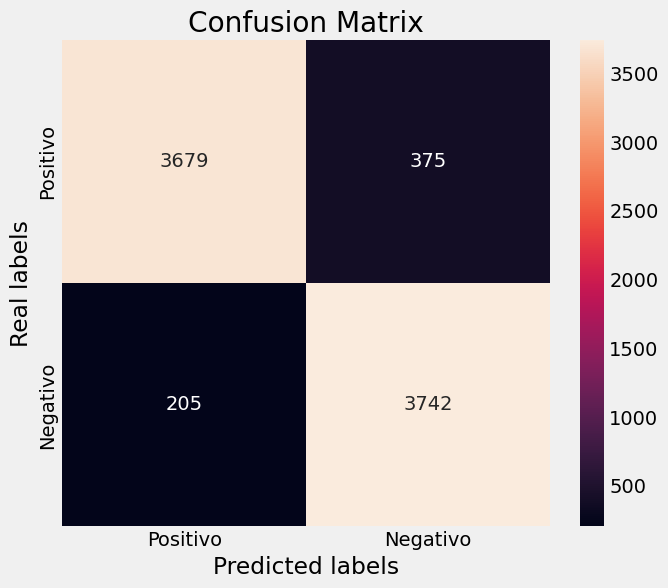

Sensibilidade:  0.95
Especificidade:  0.91


In [13]:
cm = confusion_matrix(y_test, y_pred, labels=['Positivo', 'Negativo'])
'''
default:
[[TN, FP,
  FN, TP]]
  
labels = [1,0]:
[[TP, FP,
  FN, TN]]
'''

fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(cm, annot=True, ax=ax, fmt='.0f'); 

ax.set_xlabel('Predicted labels')
ax.set_ylabel('Real labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Positivo', 'Negativo'])
ax.yaxis.set_ticklabels(['Positivo', 'Negativo']);
plt.show()

sens = cm[0,0] / (cm[0,0] + cm[1,0])
esp = cm[1,1] / (cm[0,1] + cm[1,1])

print('Sensibilidade: ', round(sens,2))
print('Especificidade: ', round(esp,2))

## Teste de entrada no modelo e Preparação dos dados
Nesta seção, realizamos o teste de entrada no modelo de análise de sentimento e preparamos os dados para classificação. Utilizando a classe DataPrep, removemos os acentos dos exemplos de teste e aplicamos a lematização. Em seguida, transformamos os exemplos de teste em vetores numéricos usando o vetorizador TF-IDF treinado anteriormente. Realizamos a classificação dos exemplos de teste utilizando o modelo de classificação Naive Bayes e exibimos as classificações preditas. Além disso, exibimos as probabilidades atribuídas a cada classe. Essas etapas permitem testar o modelo de análise de sentimento em novos exemplos de texto e obter as previsões de sentimentos correspondentes.

In [14]:
# Teste de entrada no modelo
testes = ["Excelente produto, recomendo"
         ,"Nao recebi o produto, quero meu dinheiro de volta"
         ,"não consigo encontrar maquiagem na black friday que meu bolso consegue pagar... triste & sem dinheiro"
         ,"Man tô na mesma situação tô com 100 reais na carteira da psn já a 2 semanas esperando a Black Friday pra comprar o days gone" # Padrão Twitter, modelo não conhece
         ]

# Preparação dos dados
dp = DataPrep()
testes = dp.rm_accents(testes)
corpus2 = dp.lemmatize(testes)

print("\nClassificacao Predita:")
testes_transform = vectorizer.transform(corpus2)
for i in range(len(testes)):
    print("{} {:-<16} {}".format([i+1], classifier_nb.predict(testes_transform)[i], testes[i]))

print("\nProbabilidaes:")
testes_transform = vectorizer.transform(corpus2)
for i in range(len(testes)):
    print("{} {:-<16} {}".format([i+1], str([round(x,2) for x in classifier_nb.predict_proba(testes_transform)[i].tolist()]), testes[i]))

DataPrep ready.

Classificacao Predita:
[1] Positivo-------- Excelente produto, recomendo
[2] Negativo-------- Nao recebi o produto, quero meu dinheiro de volta
[3] Negativo-------- nao consigo encontrar maquiagem na black friday que meu bolso consegue pagar... triste & sem dinheiro
[4] Negativo-------- Man to na mesma situacao to com 100 reais na carteira da psn ja a 2 semanas esperando a Black Friday pra comprar o days gone

Probabilidaes:
[1] [0.02, 0.98]---- Excelente produto, recomendo
[2] [0.99, 0.01]---- Nao recebi o produto, quero meu dinheiro de volta
[3] [0.93, 0.07]---- nao consigo encontrar maquiagem na black friday que meu bolso consegue pagar... triste & sem dinheiro
[4] [0.82, 0.18]---- Man to na mesma situacao to com 100 reais na carteira da psn ja a 2 semanas esperando a Black Friday pra comprar o days gone


## Coletar tópicos e seus pesos
A função get_topics_terms_weights recebe os pesos dos tópicos e os nomes das features (termos) e retorna uma lista de tópicos, onde cada tópico é representado por uma matriz contendo os termos e seus respectivos pesos. Os tópicos são ordenados de acordo com os pesos.

A função print_topics_udf imprime os componentes de cada tópico. É possível especificar o número total de tópicos, um limiar de peso para exibir os termos, se deseja exibir os pesos e o número máximo de termos a serem exibidos.

A função get_topics_udf é similar à print_topics_udf, mas retorna os tópicos em vez de imprimi-los. Ela retorna uma lista de tópicos, onde cada tópico é uma lista de termos. É possível especificar o número total de tópicos, um limiar de peso para incluir os termos e o número máximo de termos a serem retornados.

Essas funções são úteis para análise de tópicos em modelos de tópicos, permitindo visualizar os termos mais relevantes em cada tópico e seus respectivos pesos.

In [15]:
# Coletar tópicos e seus pesos
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])
    
    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]
    
    return topics


# Imprimir os componentes de cada tópico
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
                     
        if display_weights:
            print('Topic #'+str(index)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

def get_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     num_terms=None):
    
    topic_terms = []
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
        
        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

## Non-Negative Matrix Factorization (NMF)
Nesta seção, aplicamos a técnica de fatoração de matriz não negativa (NMF) ao conjunto de dados vetorizados. Utilizando a implementação do NMF da biblioteca scikit-learn, definimos o número de tópicos desejado e outros parâmetros relevantes. Ajustamos o modelo NMF aos dados vetorizados e extraímos os pesos dos componentes e os nomes das features. O NMF é uma técnica poderosa para análise de tópicos, permitindo identificar padrões e temas subjacentes nos dados textuais.

In [16]:
%%time
# Non-Negative Matrix Factorization (NMF))
'''
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
sklearn.decomposition.NMF(n_components=None, init=None, solver='cd', beta_loss='frobenius', 
                          tol=0.0001, max_iter=200, random_state=None, alpha=0.0, l1_ratio=0.0, 
                          verbose=0, shuffle=False)[source]
'''
from sklearn.decomposition import NMF
num_topics = 10

nmf = NMF(n_components=num_topics, random_state=42, l1_ratio=0.5, init='nndsvd')
nmf.fit(X)

nmf_weights = nmf.components_
nmf_feature_names = vectorizer.get_feature_names_out()
print(nmf)

NMF(init='nndsvd', l1_ratio=0.5, n_components=10, random_state=42)
CPU times: total: 43min 24s
Wall time: 3min 25s


Agora, coletamos os tópicos e seus pesos a partir dos pesos dos componentes do NMF e dos nomes das features, e em seguida, imprimimos os componentes de cada tópico. As funções utilizadas permitem visualizar os termos mais relevantes em cada tópico e seus respectivos pesos, fornecendo informações sobre os temas identificados pelo modelo de NMF. Essa análise é útil para compreender os principais tópicos presentes nos dados textuais e interpretar os resultados obtidos na análise de sentimento.

In [17]:
topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
print_topics_udf(topics, total_topics=num_topics, num_terms=5, display_weights=True)

Topic #0 with weights
[('qualidade', 5.93), ('otimar', 2.23), ('produto', 2.01), ('pessimo', 0.62), ('material', 0.49)]
Topic #1 with weights
[('nao', 3.05), ('vir', 0.84), ('compr', 0.76), ('funcionar', 0.75), ('comprar', 0.74)]
Topic #2 with weights
[('chegar', 3.24), ('prazo', 1.86), ('produto', 0.54), ('perfeito', 0.47), ('prever', 0.37)]
Topic #3 with weights
[('entregar', 3.75), ('prazo', 1.46), ('produto', 0.79), ('parabem', 0.48), ('rapir', 0.36)]
Topic #4 with weights
[('rapir', 3.01), ('super', 2.82), ('entrega', 0.52), ('recomendo', 0.4), ('indico', 0.3)]
Topic #5 with weights
[('otimo', 3.88), ('custo', 0.96), ('beneficio', 0.94), ('recomendar', 0.38), ('produto', 0.35)]
Topic #6 with weights
[('expectativa', 2.75), ('atender', 2.32), ('superar', 0.99), ('necessidade', 0.5), ('produto', 0.45)]
Topic #7 with weights
[('excelente', 4.16), ('produto', 0.98), ('custo', 0.25), ('beneficio', 0.23), ('recomendo', 0.18)]
Topic #8 with weights
[('recomer', 4.11), ('gostar', 1.23), (

## Transformação e inserção dos tópicos no Dataset
Nesta seção, realizamos a transformação dos dados e inserimos os tópicos identificados no conjunto de dados original. Utilizando o modelo NMF, determinamos o tópico dominante para cada documento do conjunto de dados vetorizado e o inserimos na coluna "topic" do DataFrame. Em seguida, mapeamos os índices dos tópicos para rótulos descritivos e substituímos os índices pelos rótulos correspondentes no DataFrame. Essa transformação e inserção dos tópicos no Dataset permite categorizar os documentos com base nos tópicos identificados, facilitando a análise e interpretação dos resultados da análise de sentimento.


In [18]:
topic_values = nmf.transform(X)
b2w_ml['topic'] = topic_values.argmax(axis=1)

labels = {0:'Qualidade do Produto'
         ,1:'Recebimento do Produto'
         ,2:'Prazo de Entrega'
         ,3:'Prazo de Entrega'
         ,4:'Qualidade do Produto' 
         ,5:'Qualidade do Produto' 
         ,6:'Qualidade do Produto'
         ,7:'Qualidade do Produto'
         ,8:'Qualidade do Produto'
         ,9:'Qualidade do Produto'
}

b2w_ml = b2w_ml.replace(labels)
b2w_ml.head(10)

,review_text,overall_rating,topic
0,"Como toda compra q faco na americanas a entrega e super rapida! (RJ) O sofa e maravilhoso, enorme, confortavel, material muito bom e de facil montagem.",Positivo,Qualidade do Produto
1,"TV muito boa facil de manusear, o sistema web os e muito bom rapido, so tem um problema, os LEDs estao se soltando com mais de um ano de uso, ficando uma mancha branca na tela tem varios LEDs da minha ja cairam 3, pessimo!!",Negativo,Qualidade do Produto
2,Muito bom aditivo da radiex! Excelente refrigeracao no carro.,Positivo,Qualidade do Produto
3,"Ja uso esse produto e gosto muito, recomendo a loja entrega super rapida e preco excelente",Positivo,Qualidade do Produto
4,"De boa qualidade, excelente para manusear o Vade Mecun com mais agilidade.",Positivo,Qualidade do Produto
5,Como vou avaliar meu produto se ele nem chegou ainda .,Negativo,Prazo de Entrega
6,"A qualidade do tecido nao boa, a cor branca e um pouco transparente por ser de uma malha inferior.",Negativo,Qualidade do Produto
7,"A lavadora e excelente: silenciosa, funciona bem, atendeu a todas as expectativas. A Brastemp produz otimas maquinas.",Positivo,Qualidade do Produto
8,"Comprei essa bomba e selecionei a opcao 220v Ao chegar (com atraso), me deparo com uma bomba de 127v Nao recomendo!",Negativo,Qualidade do Produto
9,Excelente o produto gostei muito irei indicar esse produto aos meu familiares,Positivo,Qualidade do Produto


In [19]:
# Distribuição Geral
print("Distribuição geral do corpus:\n", b2w_ml['topic'].value_counts(normalize=True))

# Distribuição Avaliações Negativas
print("\nDistribuição das avaliações Negativas:\n", b2w_ml['topic'][b2w_ml['overall_rating'] == 'Negativo'].value_counts(normalize=True))

Distribuição geral do corpus:
 Qualidade do Produto      0.429639
Recebimento do Produto    0.399140
Prazo de Entrega          0.171221
Name: topic, dtype: float64

Distribuição das avaliações Negativas:
 Recebimento do Produto    0.635968
Qualidade do Produto      0.232638
Prazo de Entrega          0.131393
Name: topic, dtype: float64


## Criação de Frases com Bigramas
Nesta seção, criamos frases com bigramas a partir do corpus de texto pré-processado. Utilizamos a classe Phrases do Gensim para identificar bigramas nas frases, com base em uma contagem mínima e um limiar de pontuação. Em seguida, aplicamos a classe Phraser às frases originais para criar um novo formato que permite a criação eficiente de bigramas. Essa etapa é importante para capturar combinações frequentes de palavras que podem conter informações relevantes para a análise de sentimento, melhorando a representação do texto e facilitando a extração de padrões.

In [20]:
%%time
sent = [line.split() for line in corpus]
phrases = Phrases(sent, min_count=1, threshold=2, progress_per=1000) 
bigram = Phraser(phrases)
sentences = bigram[sent]

CPU times: total: 688 ms
Wall time: 779 ms


## Construindo o Modelo Word2Vec para Análise de Sentimentos

Nesta etapa, foi construído um modelo Word2Vec para análise de sentimentos. O modelo foi configurado com os seguintes parâmetros: mínimo de ocorrências (min_count) igual a 20, tamanho da janela (window) igual a 3, algoritmo de treinamento (sg) igual a 0 (CBOW), tamanho do vetor de palavras (vector_size) igual a 100, taxa de amostragem (sample) igual a 6e-5, taxa de aprendizado inicial (alpha) igual a 0.03, taxa de aprendizado mínima (min_alpha) igual a 0.0007, número de amostras negativas (negative) igual a 20, número de threads (workers) igual a 7, e semente (seed) igual a 42. Esse modelo será utilizado para criar vetores de palavras que representam o contexto semântico dos termos presentes no conjunto de dados de análise de sentimentos.

In [21]:
w2v_model = Word2Vec(min_count=20
                    ,window=3
                    ,sg=0
                    ,vector_size=100
                    ,sample=6e-5
                    ,alpha=0.03
                    ,min_alpha=0.0007
                    ,negative=20
                    ,workers=7
                    ,seed=42)

## Treinamento e Utilização do Modelo Word2Vec para Análise de Sentimentos

O modelo Word2Vec é treinado com as sentenças do conjunto de dados para capturar o contexto semântico das palavras. Após a construção do vocabulário, o modelo é treinado por 30 épocas. Em seguida, as representações vetoriais das palavras são normalizadas, e a saída exibe o tamanho do vocabulário. As funções most_similar e similarity são utilizadas para encontrar termos semelhantes, antagônicos e calcular a similaridade entre palavras. Essas operações fornecem insights sobre as relações semânticas no contexto da análise de sentimentos. O tempo de execução é medido para avaliar o desempenho.

In [22]:
%%time
w2v_model.build_vocab(sentences, progress_per=100)

CPU times: total: 344 ms
Wall time: 349 ms


In [23]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: total: 20.6 s
Wall time: 14.2 s


(3414574, 12034020)

In [24]:
w2v_model.init_sims(replace=True)
print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Model has 2441 terms


In [25]:
# Termos mais similares
w2v_model.wv.most_similar(positive=["recomendar"])

[('excelente_recomendo', 0.9670000672340393),
 ('super_satisfeita', 0.9562567472457886),
 ('super_recomendar', 0.9560785889625549),
 ('satisfeitar_produto', 0.9543961882591248),
 ('chegar_direitinho', 0.9539479613304138),
 ('superar_espectativa', 0.953851580619812),
 ('aler_preco', 0.9530577659606934),
 ('comprar_medo', 0.9517523050308228),
 ('produto_maravilhoso', 0.9496469497680664),
 ('recomendar_compra', 0.947780966758728)]

In [26]:
# Termos mais antagônicos
w2v_model.wv.most_similar(negative=["recomendar"])

[('mandar_outro', 0.11021116375923157),
 ('solicitei_troca', 0.0720672756433487),
 ('dinheiro_voltar', 0.06860508024692535),
 ('furo', 0.05956527218222618),
 ('parafuso', 0.049469564110040665),
 ('voltagem', 0.045085012912750244),
 ('vir_faltar', 0.044715192168951035),
 ('fiz_reclamacao', 0.041063226759433746),
 ('enganar', 0.036815762519836426),
 ('rachar', 0.035995885729789734)]

In [27]:
# Similaridade entre dois termos
w2v_model.wv.similarity("comprar", 'atrasar')

0.57474244

## Visualização de Palavras Próximas em Gráfico de Dispersão com t-SNE

Este código implementa uma função chamada display_closestwords_tsnescatterplot que utiliza o algoritmo t-SNE para visualizar palavras próximas em um gráfico de dispersão. A função recebe um modelo Word2Vec treinado e uma palavra como entrada, exibindo as palavras mais próximas em relação à palavra de entrada. Essa visualização ajuda a identificar padrões e agrupamentos entre as palavras no contexto da análise de sentimentos.

In [28]:
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word, num_words=10):
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, num_words)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

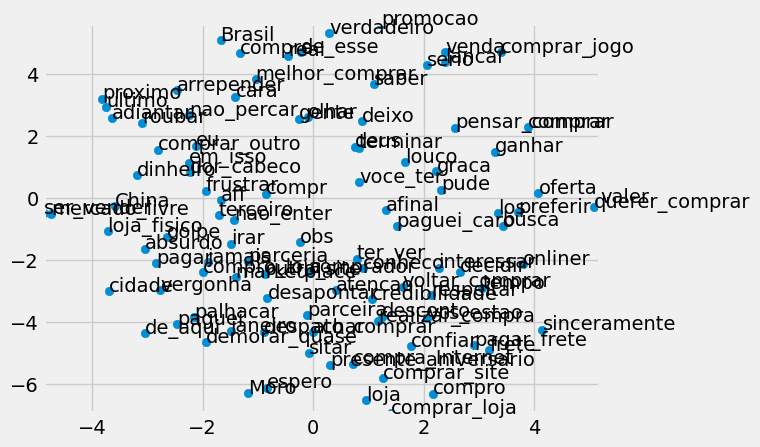

In [29]:
display_closestwords_tsnescatterplot(w2v_model, 'comprar', 100)

# Aplicação da análise de sentimento

## Análise de Sentimento em Publicações das Redes Sociais de Deputados Federais e Senadores

Nesta etapa, realizamos a aplicação da análise de sentimento em uma base de dados contendo publicações das redes sociais (Twitter e Instagram) de deputados federais e senadores referentes aos temas 'Reforma Tributária' e 'Melhorias no saneamento básico'. A base de dados foi previamente raspada e tratada previamente, incluindo com processamento de texto para já criar as colunas com os termos e temas utilizados por essas figuras públicas. 

As publicações do twitter pararam de ser raspadas há alguns meses devido às mudanças nas políticas de acesso à API da rede social.

O arquivo CSV contendo os dados é lido e armazenado no DataFrame 'politicos'. Em seguida, verificamos o formato da base de dados e exibimos as primeiras linhas para visualização. Uma nova coluna chamada 'Sentimento' é adicionada ao DataFrame deputados com valores vazios. A função rm_spam é definida para remover publicações de spam contendo URLs indesejadas. Essa função itera sobre as linhas do DataFrame, identifica e remove as publicações que contenham URLs. O DataFrame é filtrado e os duplicados são removidos com base no texto das publicações. Por fim, exibimos o novo formato da base de dados após a remoção de spam e duplicatas.

In [30]:
file = r'I:\DATA SCIENCE\Portfolio\Bases de dados\base_publicacoes_politicos.csv'
politicos = pd.read_csv(file)
print('Publicações total: ', politicos.shape)
politicos.head()
politicos.head(2)

Publicações total:  (4368, 12)


,Nome,UF,Partido,Cargo,Rede social,Publicação,Data,texto_limpo,Termos,Temas,Estado,Região
0,Efraim Filho,PB,UNIÃO,Senador,Twitter,Começamos bem 2022!! Nosso projeto virou lei. Menos impostos para quem mais emprega!!,01/01/2022,começamos bem 2022 virou menos impostos emprega,menos impostos,Reforma Tributária,Paraíba,Nordeste
1,Luis Carlos Heinze,RS,PP,Senador,Instagram,"O presidente Jair Bolsonaro sancionou a Lei 14.287, que trata da prorrogação da isenção do Imposto sobre Produtos Industrializados (IPI) para taxistas e pessoas com deficiência na compra de veículos novos. A lei beneficia pessoas com deficiência física, visual, auditiva e mental e com transtorno do espectro autista, não contempladas pela legislação anterior. É também uma forma de aquecer a ind...",03/01/2022,presidente jair sancionou 14 287 prorrogação isenção imposto produtos industrializados ipi taxistas deficiência compra veículos novos beneficia deficiência física visual auditiva mental transtorno espectro autista contempladas legislação anterior aquecer indústria automobilística senadorheinze senadordosgaúchos senadofederal ipi governofederal,imposto produtos,Reforma Tributária,Rio Grande do Sul,Sul


In [31]:
def rm_spam(df, col):
    index_list = list()
    for i in range(df.shape[0]):
        match = re.search(r"\Shttp|\bhttp", df[col][i])
        if match:
            index_list.append(i)
        else:
            continue
    df_filtered = df.drop(index_list, axis=0).reset_index(drop=True)
    return df_filtered

politicos = rm_spam(politicos, col='Publicação')
politicos = politicos.drop_duplicates('Publicação').reset_index(drop=True)
politicos.head(1)

,Nome,UF,Partido,Cargo,Rede social,Publicação,Data,texto_limpo,Termos,Temas,Estado,Região
0,Efraim Filho,PB,UNIÃO,Senador,Twitter,Começamos bem 2022!! Nosso projeto virou lei. Menos impostos para quem mais emprega!!,01/01/2022,começamos bem 2022 virou menos impostos emprega,menos impostos,Reforma Tributária,Paraíba,Nordeste


## Pré-processamento do Corpus e Análise de Sentimento

O pré-processamento do corpus das publicações dos deputados federais é realizado nesta etapa. Primeiro, as acentuações são removidas e o texto é lematizado utilizando a classe DataPrep. Em seguida, o vetorizador pré-treinado é utilizado para transformar o corpus pré-processado em uma representação numérica adequada para análise. Posteriormente, é realizado um loop para realizar a classificação de sentimento para as cinco primeiras publicações no corpus. A função predict do classificador Naive Bayes é utilizada para obter as previsões de sentimento, que são impressas junto com o texto correspondente. A mágica de linha %%time é utilizada para medir o tempo de execução dessa etapa.

In [32]:
%%time
# Pré-processamento do corpus
dp = DataPrep()
corpus_politicos = dp.rm_accents(politicos['Publicação'])
corpus_politicos = dp.lemmatize(corpus_politicos)

DataPrep ready.
CPU times: total: 24 s
Wall time: 24.3 s


In [33]:
testes_vec = vectorizer.transform(corpus_politicos)
for i in range(5):
    print("{} {:-<16} {}".format([i+1], classifier_nb.predict(testes_vec)[i], politicos.iloc[i,7]))

[1] Negativo-------- começamos bem 2022 virou menos impostos emprega
[2] Negativo-------- presidente jair sancionou 14 287 prorrogação isenção imposto produtos industrializados ipi taxistas deficiência compra veículos novos beneficia deficiência física visual auditiva mental transtorno espectro autista contempladas legislação anterior aquecer indústria automobilística senadorheinze senadordosgaúchos senadofederal ipi governofederal
[3] Positivo-------- começando trabalho participei sede governo mato grosso assinatura 40 convênios montante r 114 milhões beneficiarão 29 municípios usados obras pavimentação urbana drenagem urbanização construção espaços esportivos abastecimento água iluminação construção calçadas reforma pontes parabéns governador mauromendesoficial trabalho vem realizando prol melhoria infraestrutura estado foto deputadopauloaraujo prefeita barão melgaço xará margareth munil segunda foto prefeito olímpia zé elpidio
[4] Positivo-------- queremos redução tributos aquisição

## Classificação de Sentimento e Inserção dos Resultados no Dataset

A classificação de sentimento é realizada nos dados de teste usando o classificador Naive Bayes treinado anteriormente. As previsões de sentimento são armazenadas na variável testes_pred. Em seguida, as probabilidades de classificação para a classe "Positivo" são obtidas usando o método predict_proba e armazenadas na variável testes_probs. Os registros de sentimento são inseridos no DataFrame deputados na coluna "Sentimento". Além disso, é criada uma nova coluna chamada "Positive_Prob" para armazenar as probabilidades de serem "Positivo". Um loop itera sobre as linhas do DataFrame para preencher os valores da coluna "Positive_Prob". Por fim, as duas primeiras linhas do DataFrame são exibidas com as colunas atualizadas.

In [34]:
# Dados de classificação
testes_pred = classifier_nb.predict(testes_vec)

# Dados de probabilidade de "Positivo"
testes_probs = classifier_nb.predict_proba(testes_vec)

# Inserção dos registros no Dataset
politicos['Sentimento'] = testes_pred
    
politicos['Positive_Prob']  = 0
for i in range(politicos.shape[0]):
    politicos['Positive_Prob'].iloc[i] = testes_probs[i][0]
    
politicos.head(2)

,Nome,UF,Partido,Cargo,Rede social,Publicação,Data,texto_limpo,Termos,Temas,Estado,Região,Sentimento,Positive_Prob
0,Efraim Filho,PB,UNIÃO,Senador,Twitter,Começamos bem 2022!! Nosso projeto virou lei. Menos impostos para quem mais emprega!!,01/01/2022,começamos bem 2022 virou menos impostos emprega,menos impostos,Reforma Tributária,Paraíba,Nordeste,Negativo,0.690952
1,Luis Carlos Heinze,RS,PP,Senador,Instagram,"O presidente Jair Bolsonaro sancionou a Lei 14.287, que trata da prorrogação da isenção do Imposto sobre Produtos Industrializados (IPI) para taxistas e pessoas com deficiência na compra de veículos novos. A lei beneficia pessoas com deficiência física, visual, auditiva e mental e com transtorno do espectro autista, não contempladas pela legislação anterior. É também uma forma de aquecer a ind...",03/01/2022,presidente jair sancionou 14 287 prorrogação isenção imposto produtos industrializados ipi taxistas deficiência compra veículos novos beneficia deficiência física visual auditiva mental transtorno espectro autista contempladas legislação anterior aquecer indústria automobilística senadorheinze senadordosgaúchos senadofederal ipi governofederal,imposto produtos,Reforma Tributária,Rio Grande do Sul,Sul,Negativo,0.604836


In [35]:
politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4359 entries, 0 to 4358
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nome           4359 non-null   object 
 1   UF             4359 non-null   object 
 2   Partido        4359 non-null   object 
 3   Cargo          4359 non-null   object 
 4   Rede social    4359 non-null   object 
 5   Publicação     4359 non-null   object 
 6   Data           4359 non-null   object 
 7   texto_limpo    4359 non-null   object 
 8   Termos         4359 non-null   object 
 9   Temas          4359 non-null   object 
 10  Estado         4359 non-null   object 
 11  Região         4359 non-null   object 
 12  Sentimento     4359 non-null   object 
 13  Positive_Prob  4359 non-null   float64
dtypes: float64(1), object(13)
memory usage: 476.9+ KB


# Visualizações

Para mostrar as visualizações das análises de sentimentos, utilizamos a biblioteca matplotlib e seaborn. Com ela, produzimos alguns gráficos para visualizar as informações de forma clara - primeiro com os deputados federais e, depois, com os senadores: 

1) Gráfico de colunas com o total de Sentimento; 
2) Nuvem de palavras com as palavras na coluna 'termos' - para identificar todas as palavras utilizadas na busca nas bases de dados originais;
3) Gráfico de barras com o total por tema (Reforma Tributária e Saneamento Básico)
4) Gráfico de colunas com o total de menções aos temas por partidos, separados por sentimento
5) Linha do tempo com ambos esses temas, destacando o total mês de publicações positivas x negativas nas redes sociais. 


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

## Deputados

In [143]:
deputados = politicos[politicos['Cargo'] == 'Deputado Federal']


reforma_tributaria = deputados[deputados['Temas'] == 'Reforma Tributária']
saneamento_basico = deputados[deputados['Temas'] == 'Melhorias no saneamento básico']

deputados.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3549 entries, 810 to 4358
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nome           3549 non-null   object 
 1   UF             3549 non-null   object 
 2   Partido        3549 non-null   object 
 3   Cargo          3549 non-null   object 
 4   Rede social    3549 non-null   object 
 5   Publicação     3549 non-null   object 
 6   Data           3549 non-null   object 
 7   texto_limpo    3549 non-null   object 
 8   Termos         3549 non-null   object 
 9   Temas          3549 non-null   object 
 10  Estado         3549 non-null   object 
 11  Região         3549 non-null   object 
 12  Sentimento     3549 non-null   object 
 13  Positive_Prob  3549 non-null   float64
dtypes: float64(1), object(13)
memory usage: 415.9+ KB


### 1) Gráfico de colunas com o total de Sentimento: 

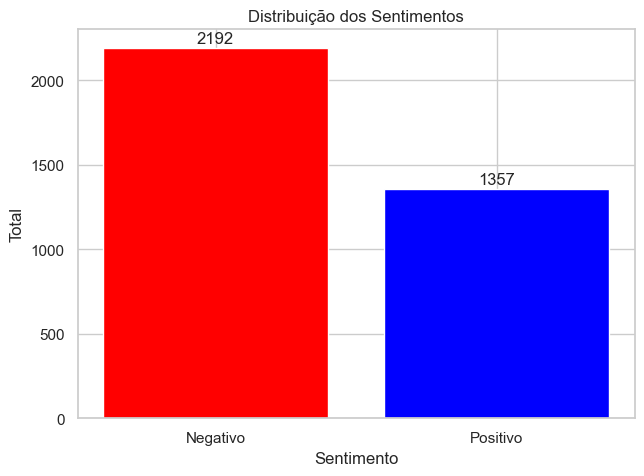

In [144]:
#Total
sentimento_counts = deputados['Sentimento'].value_counts()

cores = {'Positivo': 'blue', 'Negativo': 'red'}
colors = [cores[sentimento] for sentimento in sentimento_counts.index]

for i, v in enumerate(sentimento_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.bar(sentimento_counts.index, sentimento_counts.values, color=colors)
plt.xlabel('Sentimento')
plt.ylabel('Total')
plt.title('Distribuição dos Sentimentos')
plt.show()

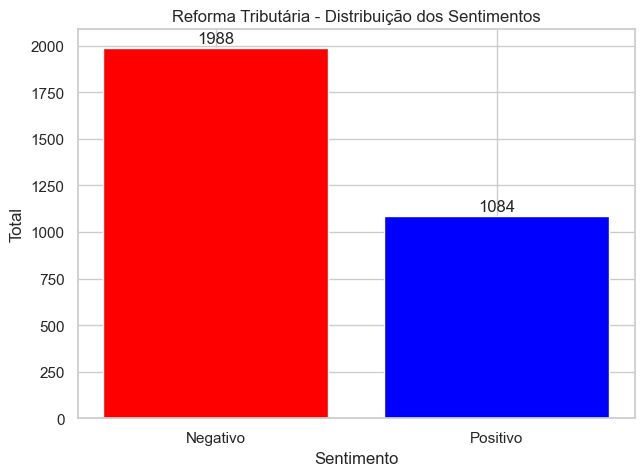

In [145]:
#Reforma Tributária
sentimento_counts = reforma_tributaria['Sentimento'].value_counts()
cores = {'Positivo': 'blue', 'Negativo': 'red'}
colors = [cores[sentimento] for sentimento in sentimento_counts.index]

for i, v in enumerate(sentimento_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.bar(sentimento_counts.index, sentimento_counts.values, color=colors)
plt.xlabel('Sentimento')
plt.ylabel('Total')
plt.title('Reforma Tributária - Distribuição dos Sentimentos')
plt.show()

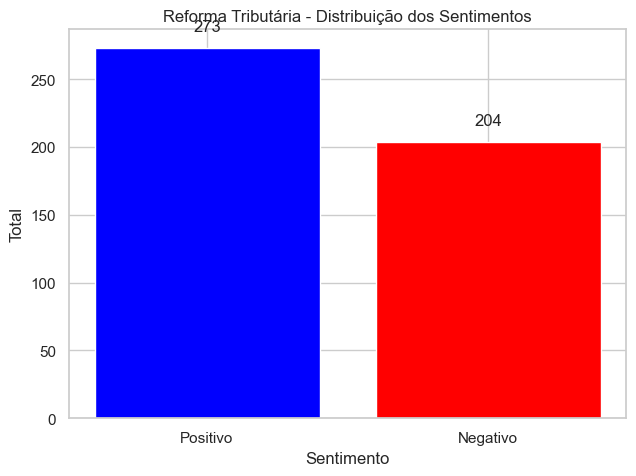

In [146]:
#Reforma Tributária
sentimento_counts = saneamento_basico['Sentimento'].value_counts()

cores = {'Positivo': 'blue', 'Negativo': 'red'}
colors = [cores[sentimento] for sentimento in sentimento_counts.index]

for i, v in enumerate(sentimento_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.bar(sentimento_counts.index, sentimento_counts.values, color=colors)
plt.xlabel('Sentimento')
plt.ylabel('Total')
plt.title('Reforma Tributária - Distribuição dos Sentimentos')
plt.show()

### 2) Nuvem de palavras com as palavras na coluna 'termos' - para identificar todas as palavras utilizadas na busca nas bases de dados originais:

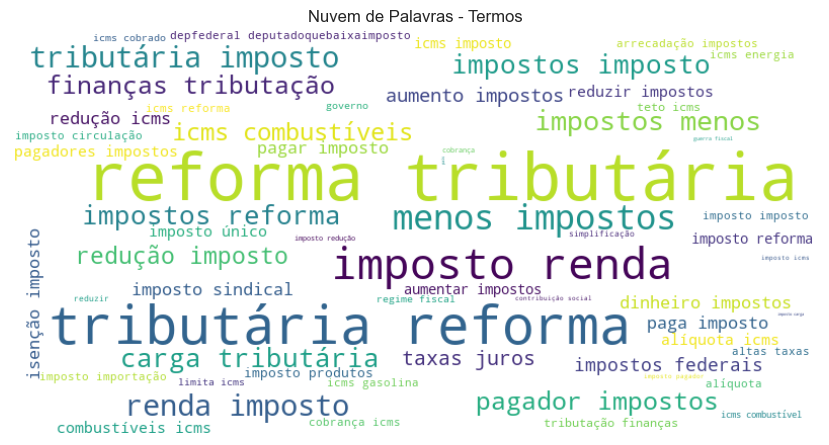

In [147]:
# reforma tributária

from wordcloud import WordCloud

all_terms = ' '.join(reforma_tributaria['Termos'].astype(str))

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(all_terms)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Termos')
plt.show()


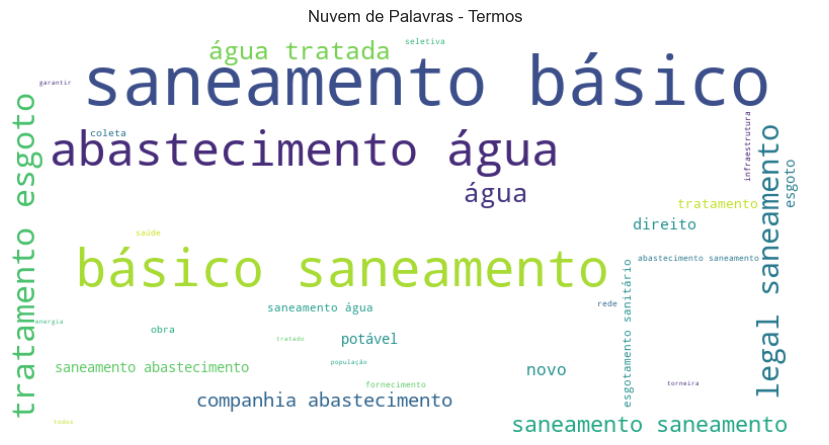

In [148]:
# Melhorias no saneamento básico

from wordcloud import WordCloud

all_terms = ' '.join(saneamento_basico['Termos'].astype(str))

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(all_terms)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Termos')
plt.show()

### 3) Gráfico de barras com o total de partido por tema

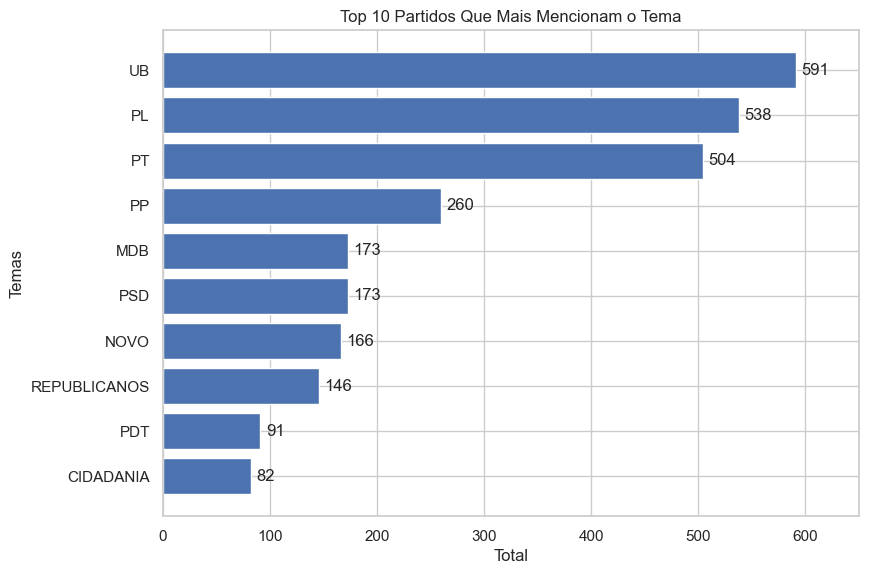

In [149]:
# Reforma Tributária

tema_counts = reforma_tributaria['Partido'].value_counts().head(10)

tema_counts = tema_counts[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(tema_counts.index, tema_counts.values)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height() / 2, width, ha='left', va='center')

plt.xlabel('Total')
plt.ylabel('Temas')
plt.title('Top 10 Partidos Que Mais Mencionam o Tema')

ax.set_xlim([0, max(tema_counts.values) * 1.1])

plt.show()

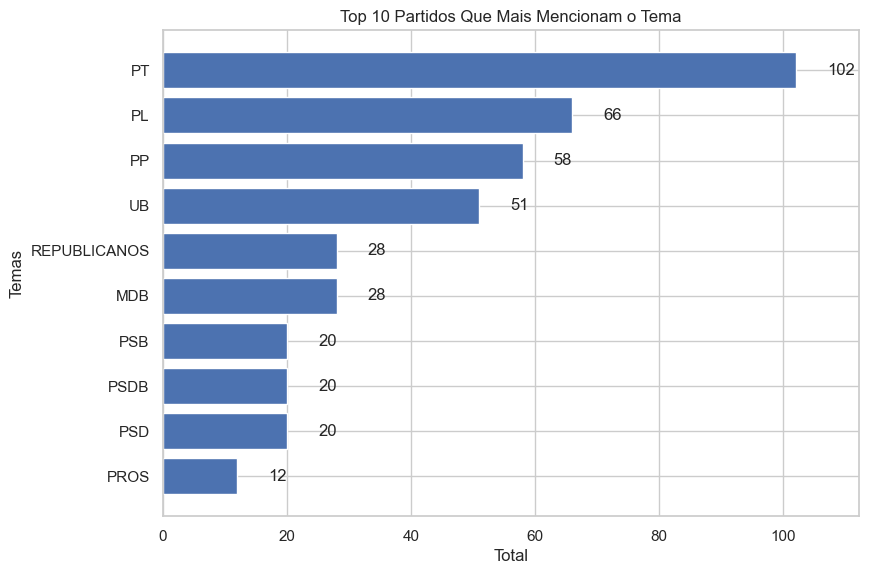

In [151]:
# Melhorias no saneamento básico

tema_counts = saneamento_basico['Partido'].value_counts().head(10)

tema_counts = tema_counts[::-1]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(tema_counts.index, tema_counts.values)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height() / 2, width, ha='left', va='center')

plt.xlabel('Total')
plt.ylabel('Temas')
plt.title('Top 10 Partidos Que Mais Mencionam o Tema')

ax.set_xlim([0, max(tema_counts.values) * 1.1])

plt.show()

### 4) Gráfico de colunas com o total de menções aos temas por partidos, separados por sentimento

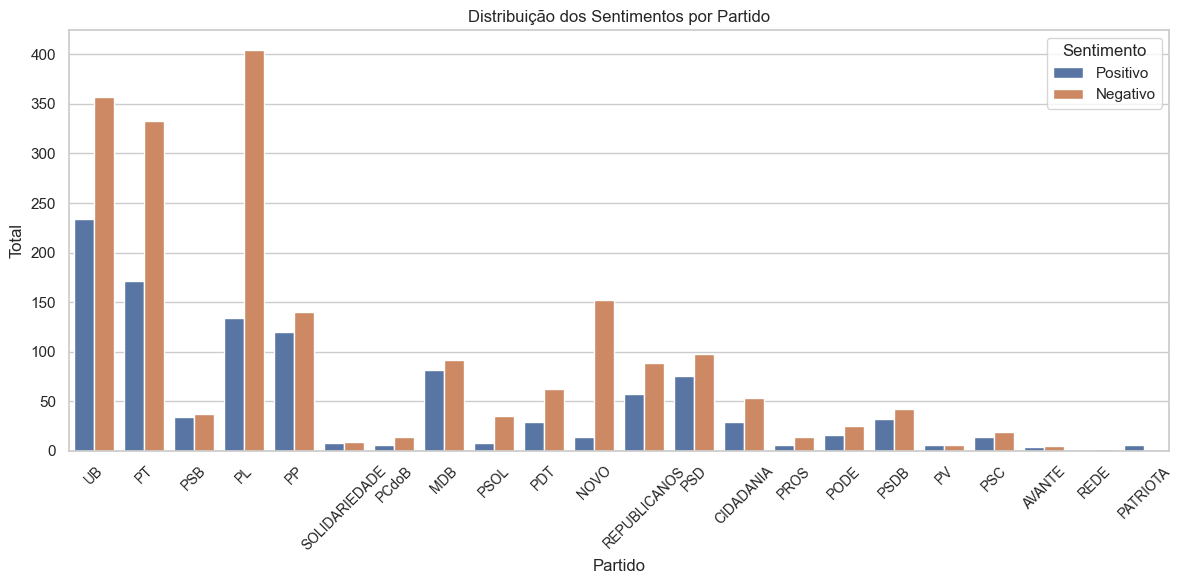

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(12, 6)) 

sns.countplot(data=reforma_tributaria, x='Partido', hue='Sentimento', hue_order=['Positivo', 'Negativo'])

plt.xlabel('Partido', fontsize=12) 
plt.ylabel('Total')
plt.title('Distribuição dos Sentimentos por Partido')
plt.legend(title='Sentimento')

plt.xticks(fontsize=10, rotation=45) 

plt.tight_layout()  

plt.show()


### 5) Linha do tempo com as menções ao tema por partido (gráfico interativo)


In [153]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo


reforma_tributaria_line_partidos = reforma_tributaria
reforma_tributaria_line_partidos['Data'] = pd.to_datetime(reforma_tributaria_line_partidos['Data']).dt.to_period('M')
reforma_tributaria_line_partidos['Data'] = reforma_tributaria_line_partidos['Data'].astype(str)
reforma_tributaria_line_partidos = reforma_tributaria_line_partidos.groupby(['Data', 'Partido']).size().reset_index(name='Total')
fig = px.line(reforma_tributaria_line_partidos, x="Data", y="Total", color='Partido', title='Reforma Tributária - Distribuição por Partido por Mês')

fig.show()

In [154]:
saneamento_basico_partidos = saneamento_basico
saneamento_basico_partidos['Data'] = pd.to_datetime(saneamento_basico_partidos['Data']).dt.to_period('M')
saneamento_basico_partidos['Data'] = saneamento_basico_partidos['Data'].astype(str)
saneamento_basico_partidos = saneamento_basico_partidos.groupby(['Data', 'Partido']).size().reset_index(name='Total')
fig = px.line(saneamento_basico_partidos, x="Data", y="Total", color='Partido', title='Saneamento Básico - Distribuição por Partido por Mês')

fig.show()

### 6) Linha do tempo com ambos esses temas, destacando o total mês de publicações positivas x negativas nas redes sociais. 

In [155]:
reforma_tributaria_sentimento = reforma_tributaria
reforma_tributaria_sentimento['Data'] = pd.to_datetime(reforma_tributaria_sentimento['Data']).dt.to_period('M')
reforma_tributaria_sentimento['Data'] = reforma_tributaria_sentimento['Data'].astype(str)
reforma_tributaria_sentimento = reforma_tributaria_sentimento.groupby(['Data', 'Sentimento']).size().reset_index(name='Total')
fig = px.line(reforma_tributaria_sentimento, x="Data", y="Total", color='Sentimento', title='Reforma Tributária - Distribuição por Partido por Mês')

fig.show()



In [156]:
saneamento_basico_sentimento = saneamento_basico
saneamento_basico_sentimento['Data'] = pd.to_datetime(saneamento_basico_sentimento['Data']).dt.to_period('M')
saneamento_basico_sentimento['Data'] = saneamento_basico_sentimento['Data'].astype(str)
saneamento_basico_sentimento = saneamento_basico_sentimento.groupby(['Data', 'Sentimento']).size().reset_index(name='Total')
fig = px.line(saneamento_basico_sentimento, x="Data", y="Total", color='Sentimento', title='Reforma Tributária - Distribuição por Partido por Mês')

fig.show()

